This is a sentimental analysis of amazon customers who have bought Alexa Products

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from xgboost import XGBClassifier

import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\l1972\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Exploration


In [44]:
data = pd.read_csv("C:\\Users\\l1972\\OneDrive\\Desktop\\Projects_ML\\NLP-SentimentAnalysis\\data\\amazon_alexa.tsv",delimiter = '\t', quoting = 3)

In [45]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [46]:
# All the features
features = [i for i in data.columns.values]

In [47]:
# Drop the NaN/ null values:
data.dropna(inplace = True)

In [48]:
# Adding a new columns called 'length' which will hold the values 
data['length_of_review'] = [len(i) for i in data['verified_reviews']]
data.head()

,rating,date,variation,verified_reviews,feedback,length_of_review
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


## For rating

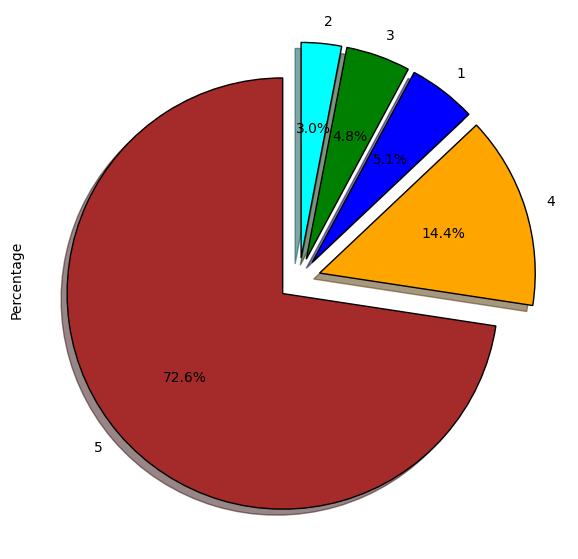

In [49]:
fig = plt.figure(figsize = (7,7))
colors = ('brown' , 'orange' , 'blue' , 'green', 'cyan')

wp = {'linewidth':1 , 'edgecolor':'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode = (0.1,0.1,0.1,0.1,0.1)

tags.plot(kind = 'pie' , autopct = '%1.1f%%' , shadow = True, colors = colors , startangle = 90, wedgeprops = wp, explode =  explode, label= 'Percentage')

from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format='png')


## for feedback

In [50]:
print(f"Feedback value count: {data['feedback'].value_counts()}")

Feedback value count: feedback
1    2893
0     256
Name: count, dtype: int64


In [51]:
# find the 'verified reviews' value for one record with feedback = 1
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


In [52]:
count_neg = 0
count_pos = 0
for i in data['feedback']:
    if i == 0:
        count_neg+=1
    else:
        count_pos+=1

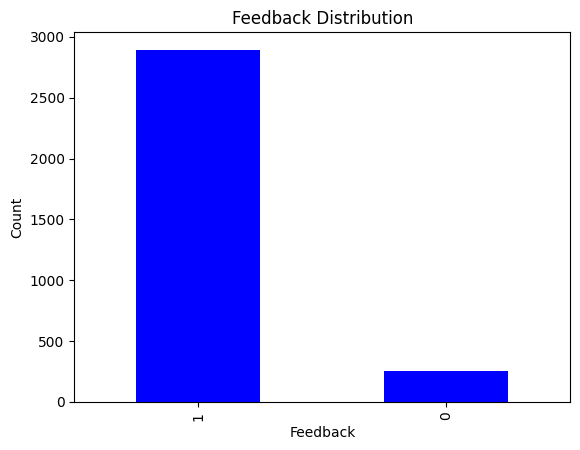

In [53]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback Distribution')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

# Modeling

* we use `countvectorizer`, which will essentially just vectorize the english words
* we use `wordcloud`,  to check the words that are more in use than the rest.

In [54]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

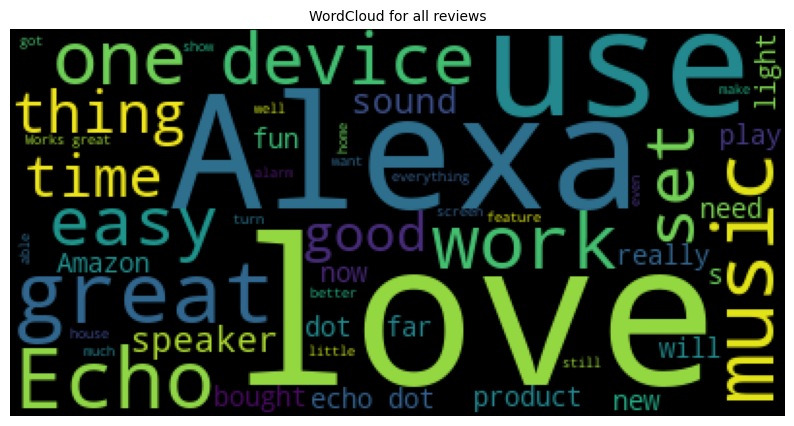

In [55]:
wc = WordCloud(background_color='black',max_words=50)
reviews = " ".join([rev for rev in data['verified_reviews']])

# generate the plot for wordcloud:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews', fontsize = 10)
plt.axis('off')
plt.show()


<h2>* Find the unique words and check category</h2>

In [56]:
neg_reviews = " ".join([rev for rev in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([rev for rev in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = " ".join(unique_neg)

unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = " ".join(unique_pos)

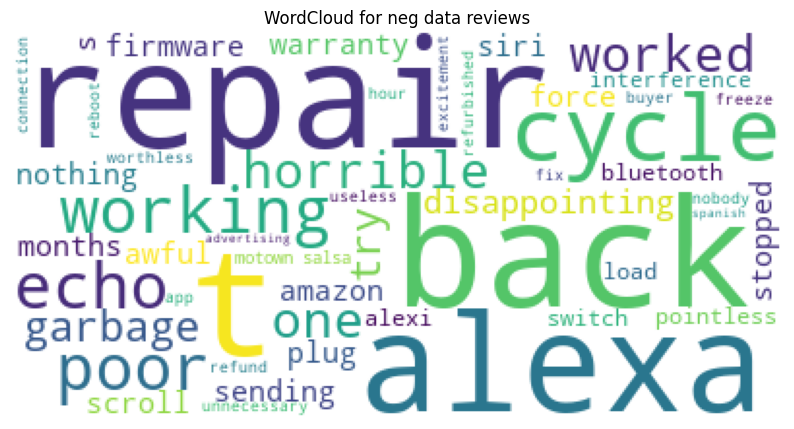

In [57]:
wc = WordCloud(background_color='white',max_words=50)

# generate and plot the wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neg))
plt.title('WordCloud for neg data reviews')
plt.axis('off')
plt.show()

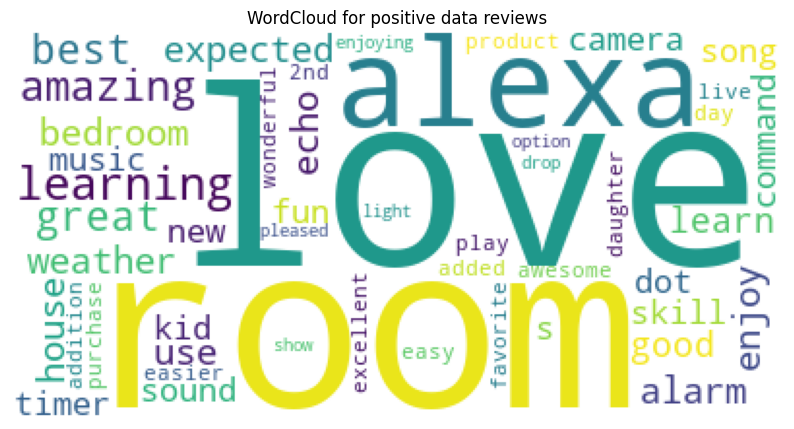

In [58]:
wc = WordCloud(background_color='white',max_words=50)
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_pos))
plt.axis('off')
plt.title('WordCloud for positive data reviews')
plt.show()

# Preprocessing and Modeling

* Replace `non-alphabetic` chars with `space`
* Convert to lower and split
* Iterate over the individual words and if it is not `stop word`, then add the stemmed form of the word to corpus.

In [59]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    rev = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    rev = rev.lower().split()
    rev = [stemmer.stem(word) for word in rev if not word in STOPWORDS]
    rev = ' '.join(rev)
    corpus.append(rev)

Use CV to create the bag of words

In [60]:
cv = CountVectorizer(max_features=2500)

x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

Save the countvectorizer model


In [61]:
pickle.dump(cv,open('countVectorizer.pkl', 'wb'))

In [62]:
# check the shape of x and y and then train and test splits

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=15)

print(f"shape of x: {x.shape}")
print(f"shape of y: {y.shape}")
print(f"shape of x_train: {x_train.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of x_test: {x_test.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of x: (3149, 2500)
shape of y: (3149,)
shape of x_train: (2519, 2500)
shape of y_train: (2519,)
shape of x_test: (630, 2500)
shape of y_test: (630,)


In [63]:
scalar = MinMaxScaler()

x_train_scaled = scalar.fit_transform(x_train)
x_test_scaled = scalar.fit_transform(x_test)

save the scalar model

In [64]:
pickle.dump(scalar, open('scalar_model.pkl', 'wb'))

<b>Random Forest model</b>

In [65]:
model = RandomForestClassifier()
model.fit(x_train_scaled,y_train)

RandomForestClassifier()

Accuracy check (scaled values can help find the training and testing accuracies)

# Analysis

In [66]:
print("Accuracy(Training): ", model.score(x_train_scaled,y_train))
print("Accuracy(Testing): ", model.score(x_test_scaled,y_test))

Accuracy(Training):  0.9952362048431918
Accuracy(Testing):  0.9492063492063492


In [67]:
y_preds = model.predict(x_test_scaled)

In [68]:
# confusion matrix
cm = confusion_matrix(y_test, y_preds)

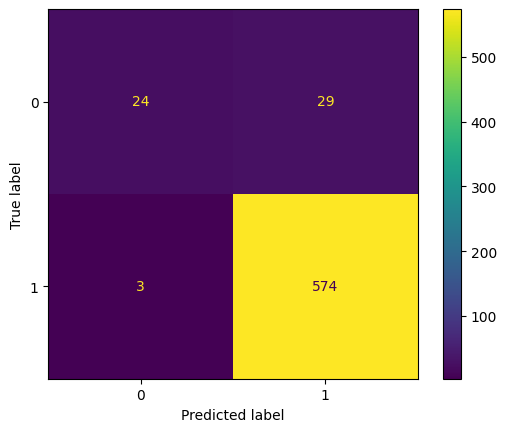

In [69]:
# Conf Mat
cm = confusion_matrix(y_test,y_preds)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()

In [70]:
# Cross_val_score
acc = cross_val_score(estimator=model,X=x_train_scaled,y=y_train,cv = 10)

print("Accuracy = ", acc.mean())
print("Standard Variance = " , acc.std())

Accuracy =  0.9376810219439701
Standard Variance =  0.012654299390819457


<b>Apply Grid search CV to get optimal params for the Random Forest

In [71]:
params = {
    'bootstrap': [True],
    'max_depth':[80,100],
    'min_samples_split': [8,12],
    'n_estimators':[100,300]
}

In [73]:
cv_obj = StratifiedKFold(n_splits=2)

gridsearch = GridSearchCV(estimator=model, param_grid = params, cv = cv_obj, verbose = 0, return_train_score = True)
gridsearch.fit(x_train, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [74]:
# Get the best parameters:

print(f'Best Parameters combinations: {gridsearch.best_params_}')

Best Parameters combinations: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [77]:
print(f"Cross Val train Score: {gridsearch.cv_results_['mean_train_score'].mean()*100}%")
print(f"Cross Val test Score: {gridsearch.cv_results_['mean_test_score'].mean()*100}%")
print(f"Accuracy for testing: {accuracy_score(y_test, y_preds)*100}%")

Cross Val train Score: 96.8291830565957%
Cross Val test Score: 92.25884740976082%
Accuracy for testing: 94.92063492063491%


<b>Applying XGBoost:

In [78]:
model_xgb = XGBClassifier()

model_xgb.fit(x_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [80]:
# Accuracy:

print(f"Training Accuracy: {model_xgb.score(x_train_scaled, y_train)*100}%")
print(f"Testing Accuracy: {model_xgb.score(x_test_scaled, y_test)*100} %")

Training Accuracy: 97.30051607780865%
Testing Accuracy: 93.4920634920635 %
